# Transport Optimal - FISE 3A - Majeure Informatique
## TP 2 - Algorithmes du Transport optimal multi-dimensionnel
### > Formulation de Kantorovich et Programmation Linéaire
### > Régularisation Entropique et Algorithme de Sinkhorn
### > [Bonus] Distance de Wasserstein Projetée 

#### julien (point) rabin @ ensicaen.fr - 2024

![](fig/logoENSI.png)
![](fig/logoPython.png)



____

## Nom : TOUJANI

### Prénom : Mohamed

### Binôme :

#### Majeure / Spécialité : INFO - CYIA

____

### Table of Contents :
<a class="anchor" id="toc"></a>

* [0. Problem setting ](#section_0) optimal transport between discrete probability distributions
    * [0-1. Reminders : Discrete Formulation of the Optimal Transport Problem ](#section_0_1) 
    * [0-2. Data (generation, plot)](#section_0_2) 
    * [0-3. Questions about admissible coupling matrices](#section_0_3)

* [I. Linear Program  ](#section_1)
    * [I-1. Exercice 1](#section_1_1)
    * [I-2. (Bonus) Exercice 2](#section_1_2)
    <!-- * [I-3. ](#section_1_3) -->
    
* [II. Entropic Regularization and Sinkhorn Algorithm ](#section_2)
    * [II.0 - Reminders](#section_2_1) 
    * [II.1 - Exercice 1 : Implementation of the Sinkhorn algorithm](#section_2_2)
    * [II.2 - (bonus) Exercice 2 : Parallel Sinkhorn algorithm](#section_2_3)

* [III. - [Bonus] Sliced Wasserstein Algorithm ](#section_3)
    * [III.1 - Exercice 1](#section_3_1)
    <!-- * [III.2 - ](#section_3_2) -->


[ToC](#toc)

In [2]:
import numpy as np 
import scipy

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['text.usetex'] = True # to use Latex in figures
#from IPython.display import display, Latex

____
# 0. Problem Setting : optimal transport between discrete probability distributions
<a class="anchor" id="section_0"></a>

## 0-1 . Reminders : Discrete Formulation of the Optimal Transport Problem 
<a class="anchor" id="section_0_1"></a>

(Ceci est un rappel des notations du cours : vous pouvez passer [à la prochaine section](#section_0_2))

**Setting** We consider the n-dimensional (nD) discrete setting with probability measures $\mu$ (source) and $\nu$ (target)
$$
\begin{cases}
%\left\{\begin{split}
\mu &= \sum_{i=1}^M \mathbf f_i \delta_{x_i}  %\mathbf{\mu}
\\
\nu &= \sum_{j=1}^N \mathbf g_j \delta_{y_j} 
\\
%\end{split}\right.
\end{cases}
$$
where :
- $\Delta_M = \left\{ \mathbf f  \in \mathbb R_+^M : \sum_{i=1}^M \mathbf f_i = 1 \right\}$ is the probability simplex
- $f \in \Delta_M$ is a probability vector (histogram), $f_i \ge 0$ indicating the probability / non-negative mass at point $x_i$
- $\mathcal X = \{x_i \in \mathbb R^d\}_{i \in [M]}$ is the set of mass locations
- $\delta_{x_0}(x) = \delta(x - x_0)$ is a Dirac delta distribution centered at $x_0$ 

**Monge-Kantorovich optimal transport formulation**
The optimal transport cost of transporting $\mu$ towards $\nu$ is the solution of the following optimization problem 
$$\textbf{MK}_{\mathbf C}(\mathbf f,\mathbf g) = \min_{\mathbf P \in \mathbb R^{M \times N}_+} 
\left\{
\sum_{i=1}^M
\sum_{j=1}^N
P_{i,j} C_{i,j}
\; \text{ s.t. }
\sum_{i=1}^M P_{i,j} = g_j \, \forall j,\;
\sum_{j=1}^N P_{i,j} = f_i \, \forall i, 
\right\}
$$
where 
- $C$ is the cost matrix which entries $C_{i,j}$ are defined by the ground cost $c$ of transporting a unit of mass from $x_i$ to $y_j$, that is
$$
    C_{i,j} = c(x_i,y_j)
$$
Note that $C$ is not necessarily positive nor symmetric
- $P$ is the coupling between $f$ and $g$, which entries $P_{i,j}$ indicates the positive amount of mass (probability) that is effectively transported from $x_i$ to $y_j$.
$P$ is a bi-stochastic matrix, meaning that the sum of each row $i$ (resp. colum $j$) match the probability $f_i$ (resp. $g_j$)

The Monge-Kantorovich optimal transport consists in finding the best coupling matrix $P$ amont all admissible ones.
Admissible matrices (but in general not optimal) includes :
- $P _{i,j}= f_i g_j$ where the mass at each source position $x_i$ is sent at every position $y_j$, in proportion with capacities $f_i$ and $g_j$
- in case of bi-partite matching where $N=M$ and $f = g = \frac 1N \mathbf 1$, admissible coupling $P$ are any (convex combinaison of) permutation matrices 


**Wasserstein Distance** When using the Euclidean distance to the power $p$ as a ground cost $c(x_i,y_j) = \|x_i-y_j\|^p $, 
the cost matrix is positive (and symmetric if $\mathcal X = \mathcal Y$), then the Monge-Kantorovich optimal cost is related to the $p$-Wasserstein distance between probability measures :
$$
    W_p (\mathbf f,\mathbf g) = \left( \textbf{MK}_{\mathbf C}(\mathbf f,\mathbf g) \right)^{\frac1p}
$$

The goal of this lab is to illustrate three different approaches to solve this problem (exactly or approximately).

## 0-2. Data (generation, plot)
<a class="anchor" id="section_0_2"></a>

To illustrate this transportation problem, we consider the following problem in 2D ($d=2$) :

- matrix $X \in \mathbb R^{M \times d}$ with $ X_{i,j} =[x_{i,j}]_{i \in [M], j \in [d]}$ indicates positions of $M$ backeries in Caen
- $f = (f_i)_{i \in [M]}$ indicates the (normalized) daily production of breads at the bakery in $x_i$
- matrix $Y \in \mathbb R^{N \times d}$ with $ Y_{i,j} =[y_{i,j}]_{i \in [N], j \in [d]}$ indicates positions of $N$ restaurants in Caen
- $g = (g_j)_{j \in [N]}$ indicates the (normalized) daily consumption of breads at restaurant in $y_j$
- $c(x_i,y_j) = \|x_i-y_j\|_2$ is the Euclidean distance for simplicity (straight-line distances rather than actual path)

Run the following code to generate and visualize $\mu$ and $\nu$ 

In [4]:
def gen_2D_data(M=8,N=20) :
    X = 3.*np.random.rand(M,2)

    radius = 4**np.random.rand(N,1)
    theta = np.random.rand(N) * (2*np.pi) 
    Y = X.mean() + np.stack((np.cos(theta), np.sin(theta)), axis=1) * radius

    # normalize coordinates in [1000 x 1000] m^2 for the map 
    X = 1000 + np.round(X*100)*3.
    Y = 1000 + np.round(Y*100)*3.
    return X,Y

def gen_prob(M) :
    f = np.random.rand(M,1) # using [M x 1] allows for matrix multiplication 
    f /= np.sum(f)
    f = .2/M + .8*f
    return f

In [5]:
# data generation

seed = 0
np.random.seed(seed)

#toy example with 2D weighted point-clouds 
d = 2 # dimension
M = 7 # for source X
N = 13 # for target Y

# (non uniform) random weights on the probbility simplex
f = gen_prob(M)
g = gen_prob(N)

# random locations
X,Y = gen_2D_data(M,N)

# cost matrix = euclidean distance 
C_XY = scipy.spatial.distance_matrix(X, Y, p=2)



In [6]:
def show_data_on_map(mu, nu) : # display weighted point clouds mu and nu
    X,f = mu
    Y,g = nu
    N = X.shape[0]

    fig,ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1], s=50 * N * f, c='b', marker='o', alpha=.5, label="source X")
    ax.scatter(Y[:,0],Y[:,1], s=50 * N * g, c='r', marker='s', alpha=.5, label="target Y")

    img = plt.imread("fig/map_caen.png")
    plt.imshow(img**.9, extent=[0, 3000, 0, 3000]) 
    plt.legend()
    plt.axis("off");

    return fig,ax


(<Figure size 640x480 with 1 Axes>, <Axes: >)

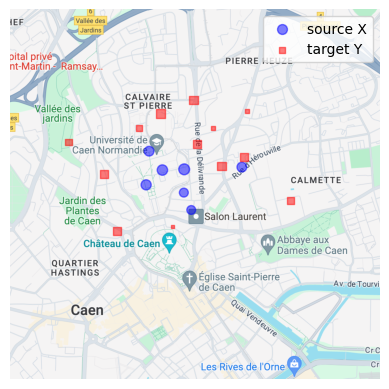

In [7]:
show_data_on_map((X,f),(Y,g))

## 0-3. Questions about admissible transport coupling matrix P
<a class="anchor" id="section_0_2"></a>

[ToC](#toc)

a - Define a random coupling matrix $P$ (for instance using numpy.random.rand)

b - Use the following function ``show_arrows_on_map`` to plot $P$

c - Check if $P$ is satisfying all constraints : 
- columns of $P$ (using `numpy.all`): $$\sum_{i=1}^M P_{i,j} = g_j \, \forall j,$$
- rows of $P$ (using `numpy.allclose` and `numpy.sum`): $$\sum_{j=1}^N P_{i,j} = f_i \, \forall i $$
- each entry of $P$ should be non-negative: $$P_{i,j} \ge 0\, \forall i,j$$
It is recommended to define a function `test_constraints(P,f,g)` performing these tests


In [8]:
def show_arrows_on_map(mu,nu,P) : # display weighted point clouds mu and nu + arrows for couplings defined by matrix P

    X,f = mu
    Y,g = nu
    N = X.shape[0]
    fig,ax = show_data_on_map(mu,nu)

    # display arrows
    X0 = np.empty((0,2))
    X1 = X0 
    W = np.empty((0))

    for i in range(M) :
        J = P[i,:]>0.
        n = np.sum(J==True)
        X0 = np.concatenate((X0,np.repeat(X[i:i+1,:],n,axis=0)), axis=0)
        X1 = np.concatenate((X1,Y[J,:]), axis=0)
        W = np.concatenate((W,P[i,J]), axis=0)

    Couleur = [np.array((1,0,1,1)) * w/np.max(W) for w in W]
    ax.quiver(X0[:,0], X0[:,1], X1[:,0]-X0[:,0], X1[:,1]-X0[:,1], angles='xy', scale_units='xy', scale = 1, color = Couleur, edgecolors='k')

    return fig,ax

Are the rows of P equal to fij for each i ?  False
Are the columns of P equal to gij for each j ?  False
Are all Pij >=0 ? True


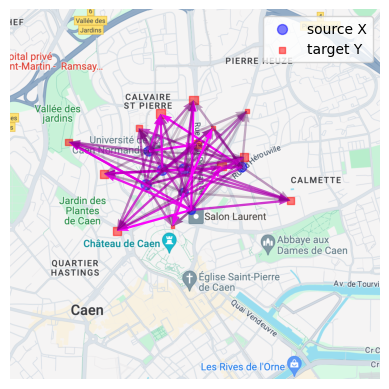

In [27]:
# your code here

P = np.random.rand(M,N)

show_arrows_on_map((X,f),(Y,g),P)

def test_constraints(P,f,g) :
    row_sums = P.sum(axis=1, keepdims=True)
    col_sums = P.sum(axis=0, keepdims=True).T

    print("Are the rows of P equal to fij for each i ? ", np.sum(np.abs(row_sums - f)) < 1e-5)
    print("Are the columns of P equal to gij for each j ? ", np.sum(np.abs(col_sums - g)) < 1e-5)
    print("Are all Pij >=0 ?", np.all(P >= 0))

test_constraints(P,f,g)

Question :

d - Compute the admissible solution $P = f g^\top$ ($P_{i,j}= f_i g_j$). Visualize $P$ as a matrix (`plt.imshow()`) and as a transportation map (``show_arrows_on_map()``)

e - Check that $P$ satisfies all constraints

f - Compute the associated transportation cost $\langle P, C \rangle = \sum_{i,j} P_{i,j} C_{i,j}$

Are the rows of P equal to fij for each i ?  True
Are the columns of P equal to gij for each j ?  True
Are all Pij >=0 ? True


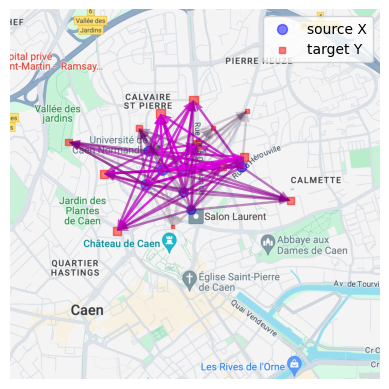

In [28]:
# your code here

P = np.multiply(f, g.T)
Cost = scipy.spatial.distance_matrix(X, Y, p=2)

show_arrows_on_map((X,f),(Y,g),P)

test_constraints(P,f,g)

g - *Bonus :* Perform a permutation on point-clouds (using `np.random.permutation`), and check that the admissible solution $P = f g^\top$ has the same transportation cost

Are the rows of P equal to fij for each i ?  True
Are the columns of P equal to gij for each j ?  True
Are all Pij >=0 ? True


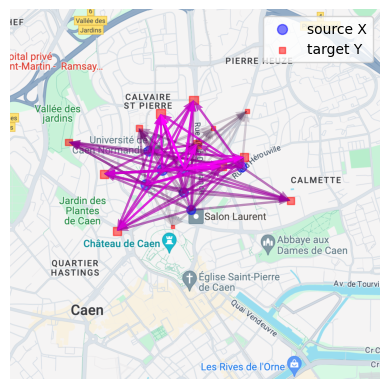

In [29]:
# your code here

# random permutation of M indices
perm = np.random.permutation(M)

# application on X and f
X_perm = X[perm,:]
f_perm = f[perm,:]
C_perm = scipy.spatial.distance_matrix(X_perm, Y, p=2)

P = np.multiply(f_perm, g.T)
Cost = scipy.spatial.distance_matrix(X_perm, Y, p=2)

show_arrows_on_map((X_perm,f_perm),(Y,g),P)

test_constraints(P,f_perm,g)

### A better admissible solution
We can perform histogram-specification (as seen in lab#1) to define a sparse admissible solution $P$.
This is also known in this context as the *North-West-Corner Rule*, and is recalled below.
This algorithm is implemented in the function ``NW()``

question h - Compute such an admissible solution $P$ with ``NW()``. 

Plot $P$ as a matrix and as a transport map.

Compute the transportation cost.

How this solution is different from the previous questions ? is it optimal ?

\
question h - *Bonus :* Check this time that using a random permutation gives a different transportation cost.

What is the complexity of finding the optimal solution by brute-force (trying all permutations) ?





**Norwest-Corner Rule**
- initialisation : 
    - $P=0_{M\times N}$ : empty coupling 
    - $i=j=1$ : we start at the top-left ("North-West") of the matrix
    - $m=f_i$ : remaining mass to be transported at this row $i$
    - $S=g_j$ : remaining mass capacity at column $j$
- while $i<M$ and $j<N$ : 
    - if $m<S$ : column is not saturated, we can move to the next row
        - $P_{ij} = m$
        - $S \leftarrow S - m$
        - $i \leftarrow i+1$
        - $m=f_i$
    - else : column is saturated, we have to move to the next column
        - $P_{ij} = S$
        - $m \leftarrow  m - S $
        - $j \leftarrow j+1$
        - $S \leftarrow g_j$

In [30]:
def NW(f,g) :

    M,N = f.size, g.size

    # init
    P = np.zeros((M,N))
    i,j = 0,0
    m = f[i,0]
    S = g[j,0]
    # North-West Corner Algorihtm
    while (i<M and j<N) :
        if m<S :
            P[i,j] = m
            S -= m
            i += 1
            if (i>= M) : break
            m = f[i,0]

        else :
            P[i,j] = S
            m -= S
            j += 1
            if (j>= N) : break
            S = g[j,0]
    return P

In [31]:
# your code here

P = NW(f,g)

cost = scipy.spatial.distance_matrix(X, Y, p=2)

test_constraints(P,f,g)

Are the rows of P equal to fij for each i ?  True
Are the columns of P equal to gij for each j ?  True
Are all Pij >=0 ? True



Now the goal is to compute the optimal coupling $P$ (minimization problem).

____
# I. Optimal Transport Formulation as a Linear Program
<a class="anchor" id="section_1"></a>

[ToC](#toc)

This is a Linear-Program (LP) which can be writen in the general form:
$$
\textbf{MK}_{\mathbf C} (\mathbf a) % \textbf{MK}_C(\mathbf f,\mathbf g)
= \min_{\mathbf p \in \mathbb R^{MN}} \left\{ \langle \mathbf p,\mathbf c \rangle : 
\mathbf p \ge \mathbf 0_{NM}, \;
\mathbf L^\top \mathbf p = \mathbf a  \right\}
$$
where, using *column-wise convertion of matrix into vectors* :
- $\mathbf a = \begin{bmatrix}\mathbf f\\\mathbf g\end{bmatrix} \in \mathbb R^{M+N}$
- $\mathbf L^\top= 
\begin{bmatrix}
\text{Id}_M  & \text{Id}_M   && \cdots && \text{Id}_M  \\
 e_1\mathbf 1_{M}^\top & e_2 \mathbf 1_{M}^\top && \cdots && e_{M}\mathbf 1_{M}^\top \\
\end{bmatrix}
=
 \begin{bmatrix}
\mathbf 1_N^\top \otimes \text{Id}_M \\
\text{Id}_N \otimes \mathbf 1_M^\top\\
\end{bmatrix}$

where
- $\otimes$ is the Kronecker product between Matrix (see https://en.wikipedia.org/wiki/Kronecker_product) : ```np.kron```
- $\text{Id}_N$ is the N-by-N identity matrix  : ```np.eye```
- $1_M = (1,...1)$ is a vector full of ones  : ```np.ones```


### 1.1 - Exercice 1 : solve the corresponding optimal transport problem 
<a class="anchor" id="section_1_1"></a>
[ToC](#toc)

Complete the following code.
\
Recommended course of action :

- compute vector `a` from `f` and `g` (e.g. using `np.concatenate`)
- compute vector `c` using column-wise reading of matrix `C_XY` (e.g. using transpose `.T` and ``.reshape``)
- compute matrix $L^\top$ (using ```np.kron``` for $\otimes$, ```np.eye``` for $Id$, ```np.ones``` for $\mathbf 1^\top$).
Plot $L^\top$ and compare with the expected result
- use ``res = scipy.optimize.linprog()`` to solve the Linear Program : https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html
- compute the optimal transport cost $MK_C(f,g)$s from the solution ``p = res.x``
- compute the optimal coupling matrix $P_{OT}$ using ``p = res.x``
- plot the coupling matrix as an image and as a transport map
- check that constraints are satisfied


In [34]:
# your code here
from scipy.optimize import linprog

a = np.concatenate((f, g)) # [f,g]
c = C_XY.T.reshape(-1) # reshape C_XY.T as a vector
one_N = np.ones((1,N))
np.eye(M)
L_T = np.vstack([
    np.kron(np.eye(M), one_N),
    np.kron(np.ones((1,M)), np.eye(N))
])

# Equality constraints : A_eq x = b_eq corresponds here to L^T p = a
b_eq = a
A_eq = L_T

# Inequality constraints : l <= p <= u : here we just have the inequality p>=0 
bounds=[(0.,None)]* N*M 

res = linprog(c, A_ub=None, b_ub=None, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
p = res.x

# optimal coupling
P_OT = p.reshape(M,N)

# transport cost
OT_cost = np.sum(P_OT * C_XY)

optimal cost is  601.6002349203491
Are the rows of P equal to fij for each i ?  True
Are the columns of P equal to gij for each j ?  True
Are all Pij >=0 ? True


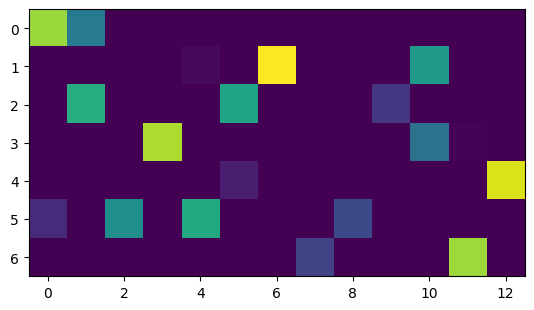

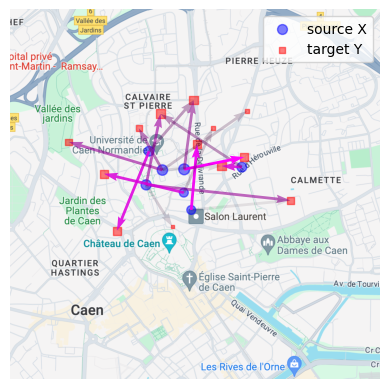

In [35]:
#-#-#-#-#-#-#-#
#   SOLUTION  #
#-#-#-#-#-#-#-#
OT_Cost = (P_OT*C_XY).sum()
print("optimal cost is ", OT_Cost)

plt.figure()
plt.imshow(P_OT)

fig,ax = show_arrows_on_map((X,f),(Y,g),P_OT)

# tests if constraints are satisfyed
test_constraints(P_OT,f,g)

### 1.2 - (bonus) Exercice 2 : time complexity
<a class="anchor" id="section_1_2"></a>

[ToC](#toc)

Use the previous code to solve problems with different values for $N=M$ up to $4 000$.\
Measure and plot computation time depending on $N$.

____
# II. Entropy-Regularized Optimal Transport Formulation and the Sinkhorn Algorithm
<a class="anchor" id="section_2"></a>

[ToC](#toc)

### II.0 - Reminders
<a class="anchor" id="section_2_0"></a>

Using matrix notations, the dual formulation of the $\varepsilon$-regularized MK transport cost between $f$ and $g$ with matrix $C$ writes :
$$
 \textbf{MK}_{\mathbf C, \varepsilon} (\mathbf f, \mathbf g)  
 = \max_{ (\boldsymbol a, \boldsymbol b)  \in \R^{M} \times \R^N}  
 \langle \boldsymbol a,  \mathbf f  \rangle +   
 \langle \boldsymbol b,  \mathbf g  \rangle
 - \varepsilon
 \langle \mathbf 1_{M\times N}, e^{ \left(  \boldsymbol a \oplus \boldsymbol b  - \mathbf C
 \right) / \varepsilon}
 \rangle  
$$
where $ (\boldsymbol a \oplus \boldsymbol b)_{i,j} = \boldsymbol a_i + \boldsymbol b_j$

The primal coupling variable $P$ writes
$\mathbf P= \text{diag}\left(\mathbf u \right) \mathbf K  \text{diag}\left( \mathbf v \right) $ 
with change of variables :
- $\mathbf K = e^{- \mathbf C / \varepsilon}$, 
- $\mathbf u = e^{\boldsymbol a / \varepsilon}$ and 
- $\mathbf v = e^{\boldsymbol b / \varepsilon}$

where $a$ and $b$ are the dual optimization variable associated to the dual formulation of the MK transport cost with matrix $C$


##### Sinkhorn Algorithm ([Cuturi'13])

Dual variables $u$ and $u$ are solution of the (convergent) fixed point equation
$$
    \mathbf u 
    = \mathbf f \oslash (\mathbf K \mathbf v) = \mathbf f \oslash (\mathbf K ( \mathbf g \oslash (\mathbf K^\top \mathbf u)  ))
$$
where 
$\oslash$ indicate element-wise division :
$$
    (f \oslash g)_i
    = f_i / g_i
$$

---
### II.1 - Exercice 1 : Implementation of the Sinkhorn algorithm
<a class="anchor" id="section_2_1"></a>

[ToC](#toc)

Recommended course of action
- set $\varepsilon = 0.1$
- compute $K$ from matrix $C_{}$ (`C_XY`)
- to avoid numerical issues, normalize $K$ in [0,1] using : $K \leftarrow K / max(K)$
- initialize $u$ and $v$ as vectors of $1$ with respectively $M$ and $N$ entries (same shape as $f$ and $g$ respectively)
- iteratively (for instance `Niter = 10` times) :
    - update $u = \mathbf f \oslash (\mathbf K \mathbf v) $
    - update $v = \mathbf g \oslash (\mathbf K^\top \mathbf u) $

Note that in python @ is matrix multiplication, and * or / is the element-wise multiplication or division 

- compute the coupling matrix $\mathbf P= \text{diag}\left(\mathbf u \right) \mathbf K  \text{diag}\left( \mathbf v \right) $ 
- compute the transportation cost $\langle P,C\rangle$ 
- Plot solution P. How does it compare to the optimal solution ?
- what happen when using smaller or larger regularization $\varepsilon$ ? for instance, from 0.01 to 1
- what happen when solving larger problem in comparison with solving the linear program (as done previously) ?

- (bonus) plot the transportation cost with respect to iteration number `Niter`
- (bonus) compute and plot the entropy of $P$
- (bonus) compute and plot computation time for different problem size with $N=M$

optimal cost is  8274.410803417162
Are the rows of P equal to fij for each i ?  False
Are the columns of P equal to gij for each j ?  False
Are all Pij >=0 ? True


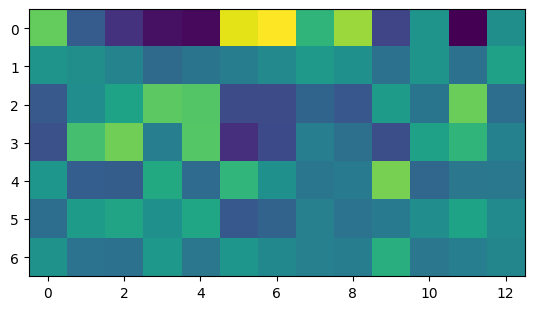

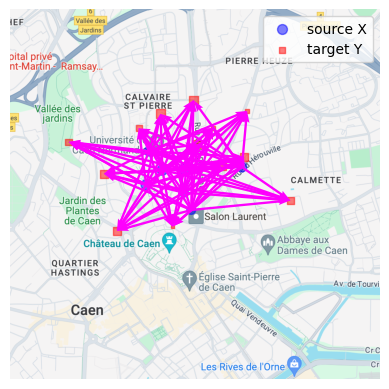

In [38]:
# your code here

# parameters
epsilon = 1e-2 # regularization parameter 
Niter = 100 # 

# cost matrix
K = C_XY.copy()
K = K / np.max(K) # normalisation
K = np.exp(-epsilon * K) # exponential with np.exp

# init
u = np.ones_like(f) # np.ones or np.ones_like
v = np.ones_like(g)

# sinkhorn iterations
for i in range(1,Niter+1) :
    u = 1 / (K @ v)
    v = 1 / (K.T @ u)

# solution
P = np.diagflat(u) @ K @ np.diagflat(v) # = diag(u) K diag(v)
transport_cost = np.sum(P * C_XY)
entropy_cost = -epsilon * np.sum(P * np.log(P + 1e-10))

# plots
# see previous section I
OT_Cost = transport_cost + entropy_cost
print("optimal cost is ", OT_Cost)

plt.figure()
plt.imshow(P)

fig,ax = show_arrows_on_map((X,f),(Y,g),P)

# tests if constraints are satisfyed
test_constraints(P,f,g)

---
### II.2 - (bonus) Exercice 2 : Parallel Sinkhorn algorithm
<a class="anchor" id="section_2_2"></a>
[ToC](#toc)

When dealing with multiple target distributions $\mu_1$, $\mu_2$, ... $\mu_K$ for the same source distribution $\nu$,
the same fixed-point equation can be used to solve *simultaneously* the $K$ transportation problems.

Implement the parallel sinkhorn algorithm.

____
# III. [Bonus] Sliced Wasserstein Distance and the Sliced Wasserstein Projection
<a class="anchor" id="section_3"></a>

[ToC](#toc)

Laset, we consider the special case of matching two point-clouds $X$ and $Y$, where 
- the number of points in the source and target are the same : $N=M$
- probability measures are uniform : $f_i = g_j = \frac 1N$

## Exercice 1 : *the Sliced-Wasserstein Distance SW_2*

THe goal of this exercice is to implement the SW_2 distance which is fast approximation of the Wasserstein distance.
When squared, the distance can be efficiently approximated with :
$$
\text{SW}_2(X,Y)^2 \approx \frac1K \sum_{\theta \in \Theta} 
   %\min_{\sigma_\theta \in \Sigma_N} 
 \sum_{i \in [N]}  \tfrac1N {\lvert \langle{x_i - y_{\sigma_\theta(i)}},{\theta} \rangle \rvert}^2 
 = \frac1K 
  \sum_{\theta \in \Theta} \sum_{i \in [N]}  \tfrac1N {\lvert \langle{x_{\sigma_{\theta,X}(i)} - y_{\sigma_{\theta,Y}(i)} },{\theta} \rangle \rvert}^2 
$$
where
- $\Theta$ is a set of $K$ random and unit vectors : $\forall \theta \in \Theta, \|\theta\| = 1$
- $\langle x_i, \theta\rangle$ is the scalar product between a point $x_i \in X$  and the vector $\theta$
- $\sigma_\theta$ is the optimal permutation of $Y$ projected on direction $\theta$, corresponding to the optimal transport of $X$ towards $Y \circ \sigma_\theta$ **after** projection on the line directed by $\theta$

Reminder (Course / Lab#1) : For N-point-clouds in the 1D case, optimal assignment can be simply defined by matching points with the same ordering rank.
The specification writes as follows : 
1) computes permutations $\sigma_X$ and $\sigma_Y$ sorting $X$ and $Y$ (in increasing order) : 
$$
    X_{\sigma_X(1)} \le X_{\sigma_X(2)} \le ... \le X_{\sigma_X(N)}
$$
and 
$$
    Y_{\sigma_Y(1)} \le Y_{\sigma_Y(2)} \le ... \le Y_{\sigma_Y(N)}
$$
2) defines "mapping" as $T: X_{\sigma_X(i)} \mapsto Y_{\sigma_Y(i)}$, that is
$$
    T: X_i \mapsto Y_{\sigma_Y\circ\sigma_X^{-1}(i)}
$$


##### Questions

- a - Generate a matrix of $K$ directions in 2D; for instance, 
    - random uniform distribution on the circle using $\theta = [\cos(2 \pi U), \sin(2 \pi U)]$ and $U \sim \mathcal U[0,1]$
    - random gaussian vectors $\theta = [X, Y] / \sqrt{X^2+Y^2}$ and $X,Y \sim \mathcal N(0,1)$ 
- b - project $X$ and $Y$ on directions $\Theta$ using matrix multiplication to get $X_\theta$ and $Y_\theta$
- c - sort projections $X_\theta$ and $Y_\theta$
- d - compute the SW_2 distance from $\|X_\theta - Y_\theta\|^2$ using appropriate normalizations
- e - (bonus) what happen for very large point clouds ? what is the complexity ?

(<Figure size 640x480 with 1 Axes>, <Axes: >)

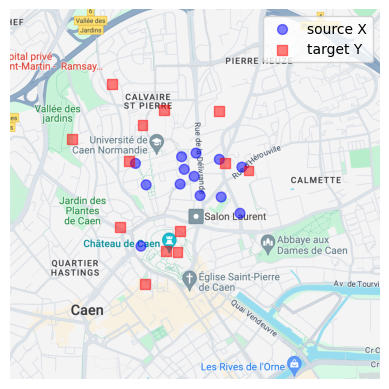

In [43]:
# generate and plot two balanced point-clouds
N = 13
d = 2

seed = 0
np.random.seed(seed)
X,Y = gen_2D_data(N,N)


f = np.ones(N)/N
g = f.copy()

show_data_on_map((X,f),(Y,g))


SW_2(X,Y) = 972549.1966542756


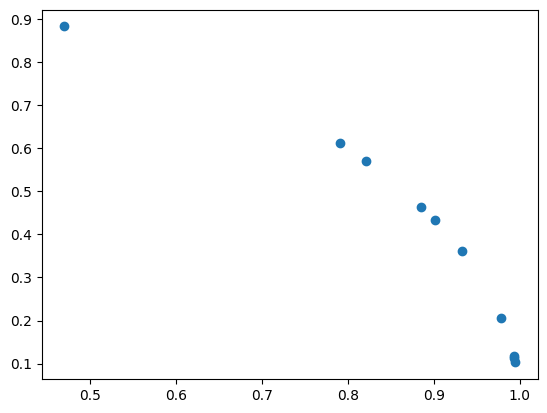

In [44]:
# your code here

# generate directions
K = 10 # number of directions
Theta = np.random.rand(K,2) # K random gaussian vectors in d=2, for instance with np.random.rand()
Theta = Theta / np.linalg.norm(Theta, axis=1, keepdims=True) # normalization or each vector

# plot directions
plt.plot(Theta[:,0], Theta[:,1], 'o')

# SW2
X_Theta = X @ Theta.T # projection on directions Theta
Y_Theta = Y @ Theta.T 

X_sort = np.sort(X_Theta, axis=0)
Y_sort = np.sort(Y_Theta, axis=0)

SW2 = np.sum((X_sort - Y_sort)**2) / K

print(f"SW_2(X,Y) = {SW2}")